In [1]:
import pandas as pd
import seaborn as sns
import glob
import os
import janitor
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

Text(0.5, 1.0, 'SARAL - Brouwer Mean Motion')

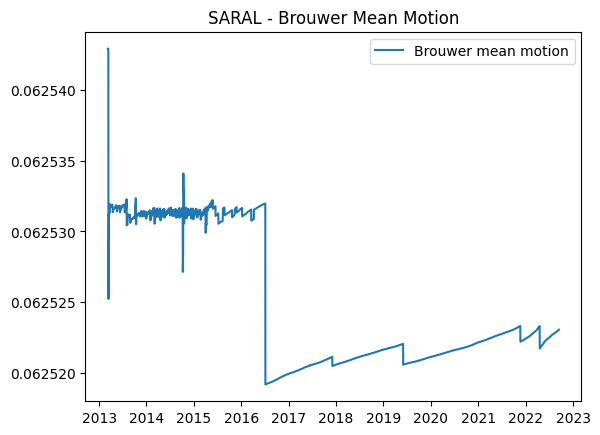

In [2]:
# Location to the file containing the csv file for the data
csv_file_path = "satellite_data/orbital_elements/unpropagated_elements_SARAL.csv"

# Reading the csv data file and creating a dataframe
df = pd.read_csv(csv_file_path, index_col = 0, parse_dates = True)

# Creating a dataframe with only the Brouwer Mean Motion
df_bmm = df[["Brouwer mean motion"]]

# Plotting the Brouwer Mean Motion
sns.lineplot(data = df_bmm)
plt.title("SARAL - Brouwer Mean Motion")

In [3]:
# Defining the format of the maneuver text file
columns_widths = [
    (0,5),      # Satellite Name
    (6,10),     # Begining of manueuver year    
    (11,14),    # Begining of manueuver day       
    (15,17),    # Begining of manueuver hour 
    (18,20),    # Begining of manueuver minute 
    (21,25),    # End of manueuver year 
    (26,29),    # End of manueuver day 
    (30,32),    # End of manueuver hour 
    (33,35),    # End of manueuver minute 
    (36,39),    # Manuever type
    (40,43),    # Manuever parameter type
    (44,45)     # Number of burns
]

# Function to parse each line based on column widths defined
def parse_line(line):
    data = [
        line[start:end].strip()
        for start, end in columns_widths
    ]
    return data

# Function to convert start and end maneuver to datetime
def convert_to_datetime(row):
    start_date = datetime.strptime(f"{row['Start_Year']} {row['Start_Day']} {row['Start_Hour']} {row['Start_Minute']}", "%Y %j %H %M")
    end_date = datetime.strptime(f"{row['End_Year']} {row['End_Day']} {row['End_Hour']} {row['End_Minute']}", "%Y %j %H %M")
    return start_date, end_date

# File path to maneuver file
maneuver_file_path = 'satellite_data/manoeuvres/srlman.txt'

# Reading the text file into a list of lines
with open(maneuver_file_path, 'r') as txt_file:
    lines = txt_file.readlines()

# Parsing each line into a list of values
parsed_data = [parse_line(line) for line in lines]

# Defining the column names
column_names = [
    'Satellite', 'Start_Year', 'Start_Day', 'Start_Hour', 'Start_Minute',
    'End_Year', 'End_Day', 'End_Hour', 'End_Minute',
    'Maneuver_Type', 'Parameter_Type', 'Number_of_Burns'
]

# Creating a dataframe with the text file data
df = pd.DataFrame(parsed_data, columns = column_names)

# Converting start and end maneuvers to datetime
df['Start_Date'], df['End_Date'] = zip(*df.apply(convert_to_datetime,axis=1))

# Checking the dataframe
print(df.head())

  Satellite Start_Year Start_Day Start_Hour Start_Minute End_Year End_Day  \
0     SARAL       2013       058         13           14     2013     058   
1     SARAL       2013       058         14           58     2013     058   
2     SARAL       2013       060         15           51     2013     060   
3     SARAL       2013       061         06           03     2013     061   
4     SARAL       2013       062         02           10     2013     062   

  End_Hour End_Minute Maneuver_Type Parameter_Type Number_of_Burns  \
0       13         19                          006               1   
1       15         04                          006               1   
2       15         53                          006               1   
3       06         05                          006               1   
4       02         12                          006               1   

           Start_Date            End_Date  
0 2013-02-27 13:14:00 2013-02-27 13:19:00  
1 2013-02-27 14:58:00 2013-0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

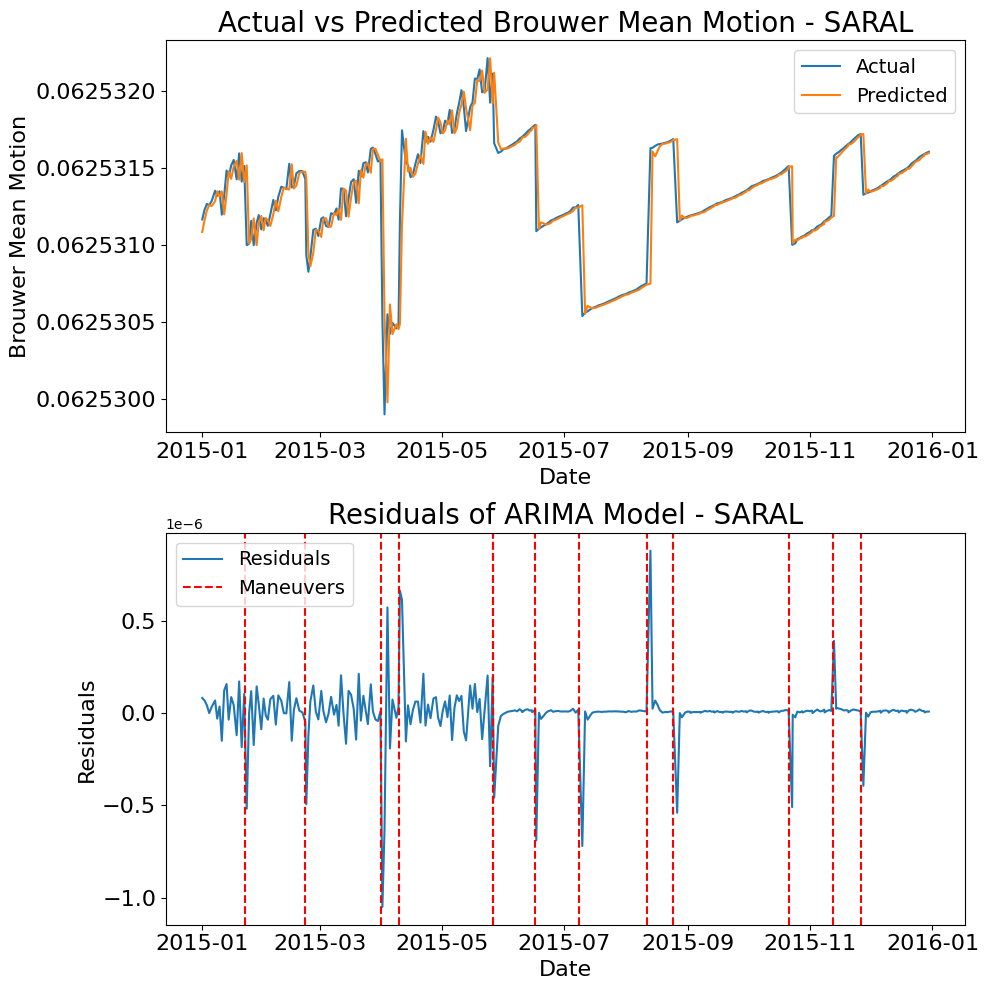

In [4]:
# Fitting an ARIMA model to the entire dataset
arima_model = ARIMA(df_bmm,order = (4,1,1))
arima_model_fit = arima_model.fit()

# Making predictions
predictions = arima_model_fit.predict(start = 0, end = len(df_bmm) - 1, typ = 'levels')

# Calculating residuals
residuals = df_bmm['Brouwer mean motion'] - predictions

# Defining date ranges
start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2015-12-31")

# Filtering the actual, predictions and residuals based on the date range
actual_filtered = df_bmm[start_date:end_date]
predictions_filtered = predictions[start_date:end_date]
residuals_filtered = residuals[start_date:end_date]

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize = (10,10))

# Plotting actual vs predicted values
sns.lineplot(x = actual_filtered.index, y = actual_filtered["Brouwer mean motion"], label = "Actual", ax = axes[0])
sns.lineplot(x = predictions_filtered.index, y = predictions_filtered, label = "Predicted", ax = axes[0])
axes[0].set_title("Actual vs Predicted Brouwer Mean Motion - SARAL",fontsize=20)
axes[0].set_xlabel("Date",fontsize=16)
axes[0].set_ylabel("Brouwer Mean Motion",fontsize=16)
axes[0].legend(fontsize=14)
axes[0].tick_params(axis='both',labelsize=16)

# Plotting residuals
sns.lineplot(x = residuals_filtered.index, y = residuals_filtered, label = "Residuals", ax = axes[1])
axes[1].set_title("Residuals of ARIMA Model - SARAL",fontsize=20)
axes[1].set_xlabel("Date", fontsize=16)
axes[1].set_ylabel("Residuals", fontsize=16)
axes[1].tick_params(axis='both',labelsize=16)

# Filtering maneuvers based on the date range
maneuvers_filtered = df[df["Start_Date"] >= start_date]
maneuvers_filtered = maneuvers_filtered[maneuvers_filtered["Start_Date"] <= end_date]

# Marking maneuvers on the residuals plot
maneuver_dates = maneuvers_filtered['Start_Date']
first_label = True
for maneuver_date in maneuver_dates:
    if first_label:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--', label = "Maneuvers")
        first_label = False
    else:
        axes[1].axvline(x = maneuver_date, color = 'red', linestyle = '--')     
axes[1].legend(fontsize=14)

plt.tight_layout()
plt.show()

In [5]:
# Getting absolute values of the residuals for the anomaly statistic as a series
residuals_series = residuals.abs()
residuals_series = pd.Series(residuals_series, index = df_bmm.index)
residuals_series

2013-03-10 13:13:33.964320    6.254292e-02
2013-03-11 22:45:10.058975    1.995357e-08
2013-03-13 01:34:26.835167    1.027881e-07
2013-03-14 02:43:30.192095    1.758937e-05
2013-03-15 18:57:49.375584    5.721936e-06
                                  ...     
2022-09-10 11:47:30.833376    9.793881e-09
2022-09-11 12:56:41.592191    1.137603e-08
2022-09-12 12:25:15.614976    1.569561e-08
2022-09-13 03:30:46.060415    4.072417e-09
2022-09-14 04:39:56.791584    1.126265e-08
Length: 3290, dtype: float64

In [6]:
# Sorting the residuals
residuals_series.sort_values
residuals_series

2013-03-10 13:13:33.964320    6.254292e-02
2013-03-11 22:45:10.058975    1.995357e-08
2013-03-13 01:34:26.835167    1.027881e-07
2013-03-14 02:43:30.192095    1.758937e-05
2013-03-15 18:57:49.375584    5.721936e-06
                                  ...     
2022-09-10 11:47:30.833376    9.793881e-09
2022-09-11 12:56:41.592191    1.137603e-08
2022-09-12 12:25:15.614976    1.569561e-08
2022-09-13 03:30:46.060415    4.072417e-09
2022-09-14 04:39:56.791584    1.126265e-08
Length: 3290, dtype: float64

In [7]:
# Getting the maneuver time stamps into a series in date time format
maneuver_dates_series = pd.Series(pd.to_datetime(df.Start_Date))
maneuver_dates_series

0    2013-02-27 13:14:00
1    2013-02-27 14:58:00
2    2013-03-01 15:51:00
3    2013-03-02 06:03:00
4    2013-03-03 02:10:00
             ...        
57   2017-12-02 12:32:00
58   2019-06-01 13:29:00
59   2021-11-20 12:18:00
60   2022-04-18 11:08:00
61   2022-09-21 11:46:00
Name: Start_Date, Length: 62, dtype: datetime64[ns]

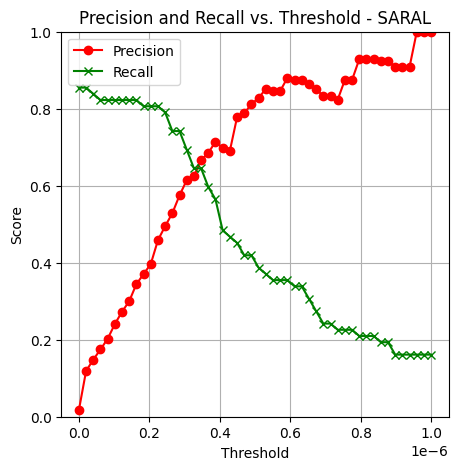

In [8]:
import pandas as pd
import numpy as np

def convert_timestamp_series_to_epoch(series):
    return (
        (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
    ).values

def compute_simple_matching_precision_recall_for_one_threshold(
    float_matching_max_days,
    float_threshold,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    """
    :param float_matching_max_days:
    :param float_threshold:
    :param pd_series_ground_truth_manoeuvre_timestamps:
    :param pd_series_predictions: The index of this series should be the timestamps of the predictions.
    :return: (precision, recall)

   Computes the precision and recall at one anomaly threshold.

   Does this using an implementation of the framework proposed by Zhao:
   Zhao, L. (2021). Event prediction in the big data era: A systematic survey. ACM Computing Surveys (CSUR), 54(5), 1-37.
   https://doi.org/10.1145/3450287

   The method matches each manoeuvre prediction with the closest ground-truth manoeuvre, if it is within a time window.

   Predictions with a match are then true positives and those without a match are false positives. Ground-truth manoeuvres
   with no matching prediction are counted as false negatives.
   """

    matching_max_distance_seconds = pd.Timedelta(days=float_matching_max_days).total_seconds()

    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    np_manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(pd_series_ground_truth_manoeuvre_timestamps)
    np_pred_time_stamps_seconds = convert_timestamp_series_to_epoch(pd_series_predictions.index)
    np_predictions = pd_series_predictions.to_numpy()

    for i in range(np_predictions.shape[0]):
        if np_predictions[i] >= float_threshold:
            left_index = np.searchsorted(
                np_manoeuvre_timestamps_seconds, np_pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < pd_series_ground_truth_manoeuvre_timestamps.shape[0] - 1) and (
                abs(np_manoeuvre_timestamps_seconds[left_index] - np_pred_time_stamps_seconds[i])
                > abs(np_manoeuvre_timestamps_seconds[left_index + 1] - np_pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(np_manoeuvre_timestamps_seconds[index_of_closest] - np_pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = (
                    index_of_closest,
                    diff,
                )
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    np_positive_prediction_indices = np.argwhere(np_predictions >= float_threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in np_positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth.keys()
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(pd_series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions.keys()
    ]

    precision = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_positives)) if (len(dict_ground_truth_to_predictions) + len(list_false_positives)) > 0 else 0
    recall = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) if (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) > 0 else 0

    total_negatives = len(np_predictions) - len(pd_series_ground_truth_manoeuvre_timestamps)
    fpr = len(list_false_positives)/total_negatives

    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall)/(precision + recall)

    return (precision, recall, fpr, f1_score)

# Create plot with precision and recall values for different thresholds
def plot_precision_recall_against_threshold_curve(threshold_range, precisions, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, precisions, marker='o', label='Precision', color='red')
    plt.plot(threshold_range, recalls, marker='x', label='Recall', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Threshold - SARAL')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculating precision and recall for multiple thresholds
def compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    pd_series_ground_truth_manoeuvre_timestamps,
    pd_series_predictions,
):
    precisions = []
    recalls = []
    fprs = []
    f1_scores = []

    for threshold in threshold_range:
        precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            threshold,
            pd_series_ground_truth_manoeuvre_timestamps,
            pd_series_predictions,
        )
        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        f1_scores.append(f1_score)

    return precisions, recalls, fprs, f1_scores

if __name__ == "__main__":

    float_matching_max_days = 3
    threshold_range = np.linspace(0,0.000001,50)

    precisions, recalls, fprs, f1_scores = compute_precision_recall_fpr_for_multiple_thresholds(
    float_matching_max_days,
    threshold_range,
    maneuver_dates_series,
    residuals_series,
    )

    plot_precision_recall_against_threshold_curve(threshold_range,precisions,recalls)

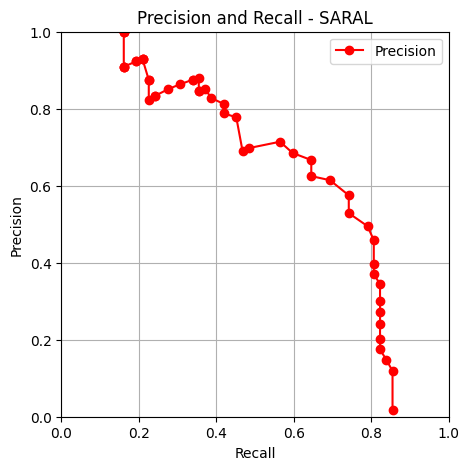

In [9]:
# Create plot with precision and recall
def plot_precision_recall_curve(precisions, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(recalls, precisions, marker = 'o', label='Precision', color='red')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision and Recall - SARAL')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_curve(precisions, recalls)

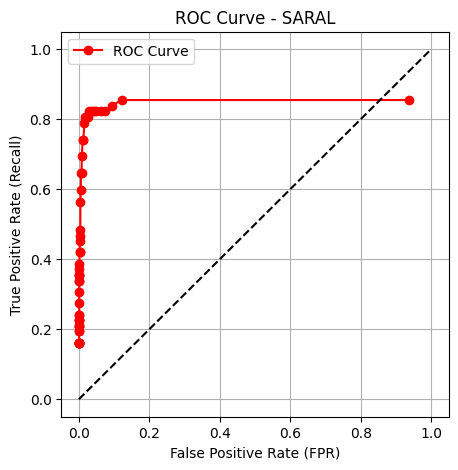

In [10]:
# Create roc plot
def plot_roc_curve(fprs, recalls):
    plt.figure(figsize=(5,5))
    plt.plot(fprs, recalls, marker = 'o', label = 'ROC Curve', color='red')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve - SARAL')
    plt.plot([0,1], [0,1], 'k--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curve(fprs, recalls)

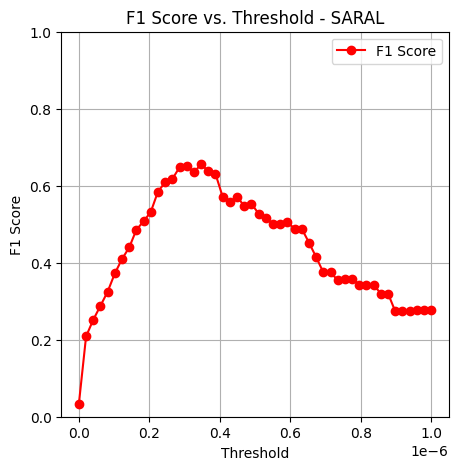

In [11]:
# Create f1_score vs threshold
def plot_f1_score_curve(threshold_range, f1_scores):
    plt.figure(figsize=(5,5))
    plt.plot(threshold_range, f1_scores, marker = 'o', label = 'F1 Score', color='red')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold - SARAL')
    plt.ylim(0,1)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_f1_score_curve(threshold_range, f1_scores)

In [12]:
# Finding the max f1 score and the relevant threshold
max_index = np.argmax(f1_scores)
max_val = f1_scores[max_index]
max_val_threshold = threshold_range[max_index]

print(max_val)
print(max_val_threshold)

0.6557377049180327
3.4693877551020406e-07


In [13]:
# Finding the precision and recall for max f1 score
precision, recall, fpr, f1_score = compute_simple_matching_precision_recall_for_one_threshold(
            float_matching_max_days,
            max_val_threshold,
            maneuver_dates_series,
            residuals_series,
        )

print(precision)
print(recall)

0.6666666666666666
0.6451612903225806


In [14]:
from sklearn.metrics import auc

auc = auc(recalls,precisions)
auc

0.48530201486798